In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from keras.layers import Dense, Dropout
from keras.models import Sequential

In [3]:
os.chdir(r'N:\Heart Disease Classification')

In [4]:
df_heart = pd.read_csv('./heart.csv')
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df_heart.shape

(303, 14)

### Descriptive Statistics & Data Cleaning

In [6]:
df_heart = df_heart.rename(columns= {'cp':'chest_pain_type','trestbps':'resting_BP','chol':'serum_cholestoral','fbs':'fasting_blood_sugar','restecg':'resting_ECG',
                                     'thalach':'max_heart_rate','exang':'exercise_induced_angina',
                                     'ca':'major_vessels_count','thal':'thalium_stress'})
df_heart.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_BP', 'serum_cholestoral',
       'fasting_blood_sugar', 'resting_ECG', 'max_heart_rate',
       'exercise_induced_angina', 'oldpeak', 'slope', 'major_vessels_count',
       'thalium_stress', 'target'],
      dtype='object')

In [7]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                        303 non-null int64
sex                        303 non-null int64
chest_pain_type            303 non-null int64
resting_BP                 303 non-null int64
serum_cholestoral          303 non-null int64
fasting_blood_sugar        303 non-null int64
resting_ECG                303 non-null int64
max_heart_rate             303 non-null int64
exercise_induced_angina    303 non-null int64
oldpeak                    303 non-null float64
slope                      303 non-null int64
major_vessels_count        303 non-null int64
thalium_stress             303 non-null int64
target                     303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [8]:
df_heart.isnull().sum()

age                        0
sex                        0
chest_pain_type            0
resting_BP                 0
serum_cholestoral          0
fasting_blood_sugar        0
resting_ECG                0
max_heart_rate             0
exercise_induced_angina    0
oldpeak                    0
slope                      0
major_vessels_count        0
thalium_stress             0
target                     0
dtype: int64

In [9]:
categorical_cols = []
continous_cols = []

for column in df_heart.columns:
    if(len(df_heart[column].unique()) <= 10):
        categorical_cols.append(column)
    else:
        continous_cols.append(column)

In [10]:
categorical_cols

['sex',
 'chest_pain_type',
 'fasting_blood_sugar',
 'resting_ECG',
 'exercise_induced_angina',
 'slope',
 'major_vessels_count',
 'thalium_stress',
 'target']

In [11]:
continous_cols

['age', 'resting_BP', 'serum_cholestoral', 'max_heart_rate', 'oldpeak']

In [12]:
df_heart_tmp = df_heart.copy()
for cols in categorical_cols:
    if(cols != 'target'):
        df_heart_tmp[cols] = df_heart_tmp[cols].astype('object')

In [13]:
df_heart_tmp.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_BP                   int64
serum_cholestoral            int64
fasting_blood_sugar         object
resting_ECG                 object
max_heart_rate               int64
exercise_induced_angina     object
oldpeak                    float64
slope                       object
major_vessels_count         object
thalium_stress              object
target                       int64
dtype: object

In [14]:
df_heart_tmp.describe()

,age,resting_BP,serum_cholestoral,max_heart_rate,oldpeak,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.544554
std,9.082101,17.538143,51.830751,22.905161,1.161075,0.498835
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,1.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,1.000000


In [15]:
df_heart_tmp.describe(include='object')

,sex,chest_pain_type,fasting_blood_sugar,resting_ECG,exercise_induced_angina,slope,major_vessels_count,thalium_stress
count,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4
top,1,0,0,1,0,2,0,2
freq,207,143,258,152,204,142,175,166


### Target Distribution

In [16]:
df_heart.target.value_counts()

1    165
0    138
Name: target, dtype: int64

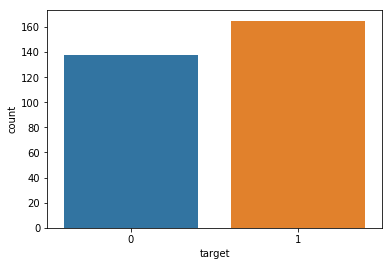

In [17]:
sns.countplot(df_heart['target'])

The data is not highly imbalanced, but I will try to balance it using SMOTE Oversampling.

### Exploratory Data Analysis

### Continous Features 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000170ECA19EB8>,
      dtype=object)

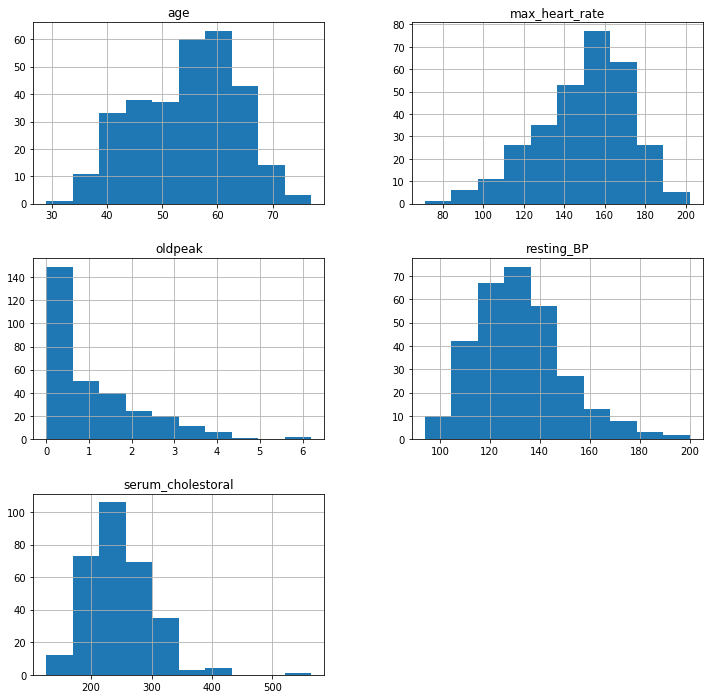

In [18]:
df_heart.hist(column=continous_cols, figsize=(12,12))

C:\Users\nikhi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


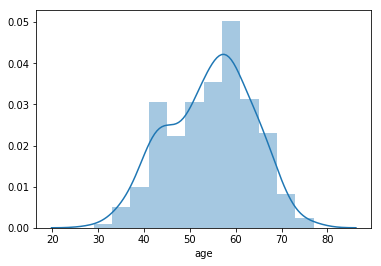

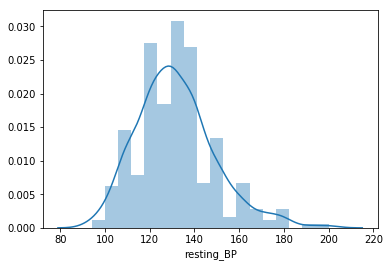

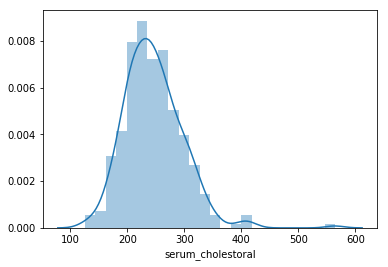

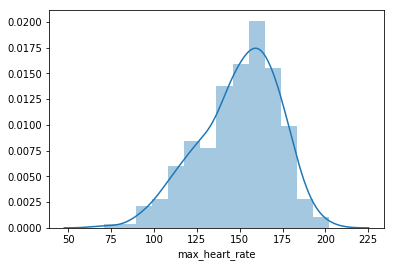

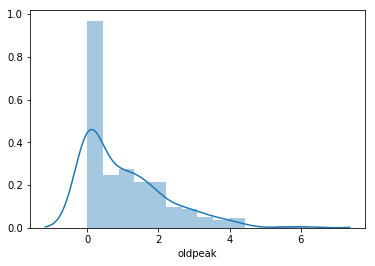

In [19]:
for index, column in enumerate(continous_cols):
    plt.figure(index)
    sns.distplot(df_heart[column])

Old Peak seems to be highly skewed, lets see the Skew for each feature. 
The skew result show a positive (right) or negative (left) skew. Values closer to zero show less skew.

In [20]:
df_heart[continous_cols].skew()

age                 -0.202463
resting_BP           0.713768
serum_cholestoral    1.143401
max_heart_rate      -0.537410
oldpeak              1.269720
dtype: float64

As evident from the Skew values above for continous features, oldpeak & serum cholestoral are right skewed. I will apply Log Transformation to these variables while Preprocessing data for Machine Learning.

#### Distribution of Categorical Values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000170EE1A7F28>,
      dtype=object)

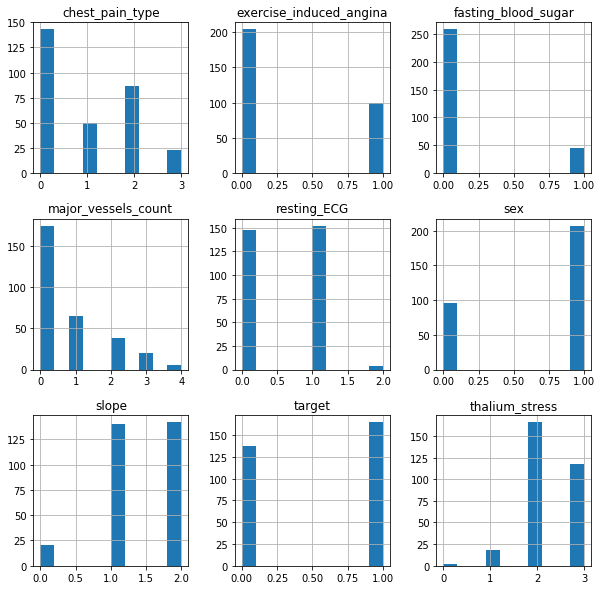

In [21]:
df_heart.hist(column=categorical_cols, figsize=(10,10))

### Associations & Correlation between variables

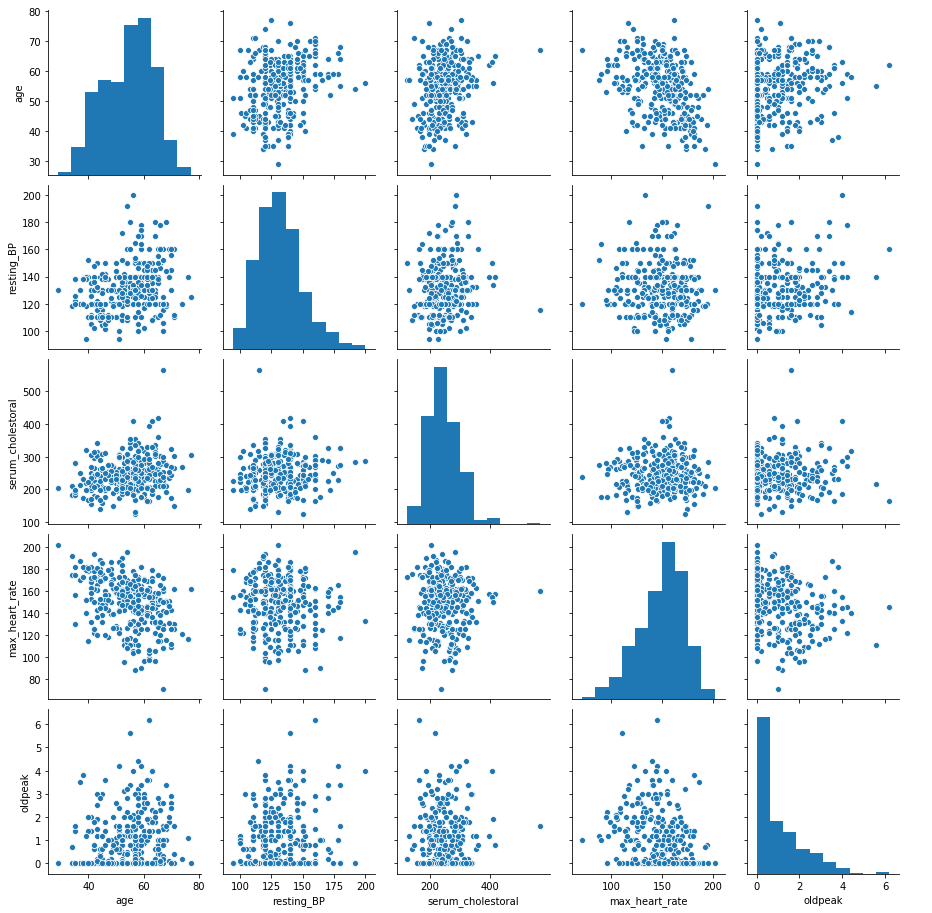

In [22]:
sns.pairplot(df_heart[continous_cols])

In [23]:
df_heart.corr()

,age,sex,chest_pain_type,resting_BP,serum_cholestoral,fasting_blood_sugar,resting_ECG,max_heart_rate,exercise_induced_angina,oldpeak,slope,major_vessels_count,thalium_stress,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
chest_pain_type,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
resting_BP,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
serum_cholestoral,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fasting_blood_sugar,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
resting_ECG,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
max_heart_rate,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exercise_induced_angina,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


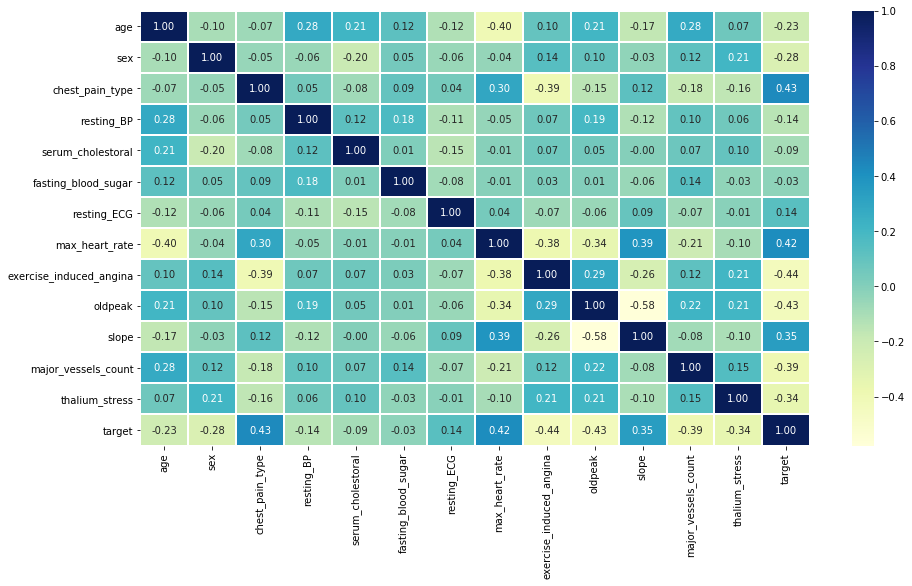

In [24]:
plt.figure(figsize=(15,8))
sns.heatmap(df_heart.corr(), annot=True, linewidths=1, linecolor='white', fmt=".2f",
                 cmap="YlGnBu")

Features do not have very high correlation with each other, which is a good thing. Lets check the correlation of each Independent feature with the Target variable. 

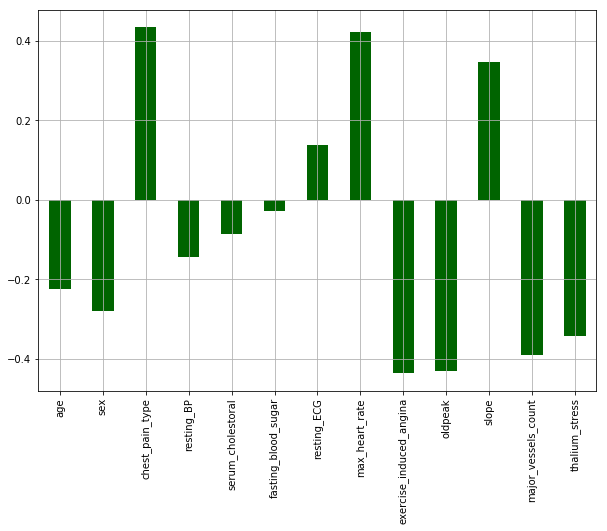

In [25]:
df_heart.drop('target', axis=1).corrwith(df_heart.target).plot(kind='bar', grid=True, figsize=(10, 7), color='darkgreen')

Most features have a significant correlation with the Target variable except Fasting Blood Sugar and Serum Cholestoral. 
Chest pain type and Max heart rate has a high positive correlation with the target

### Analysing Relationship between continous variables & Target

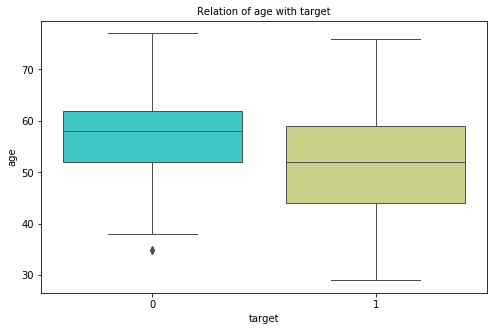

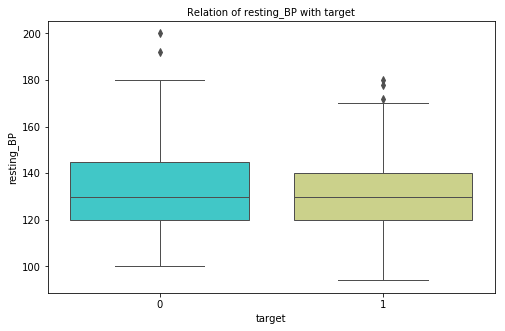

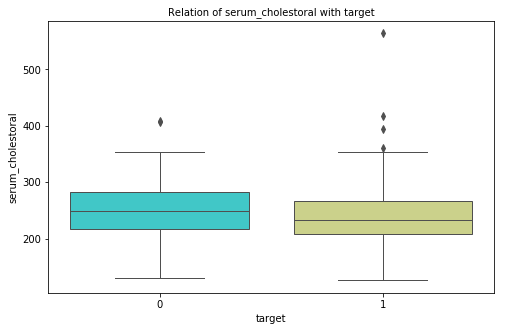

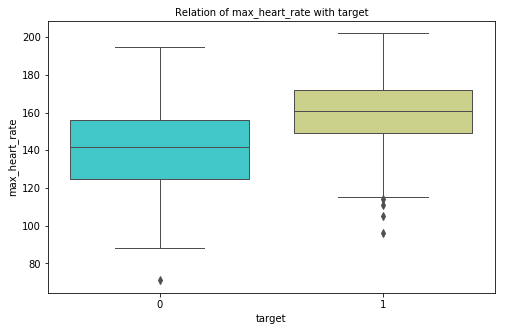

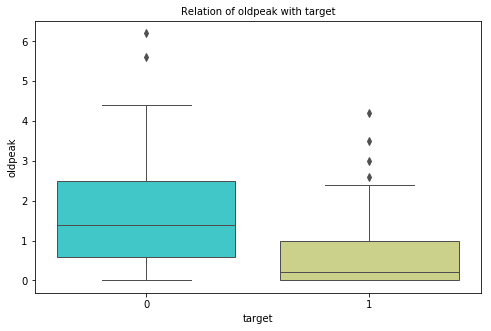

In [26]:
for index,column in enumerate(continous_cols):
    plt.figure(index, figsize=(8,5))
    sns.boxplot(x=df_heart.target, y=column, data=df_heart, palette='rainbow',linewidth=1)
    plt.title('Relation of {} with target'.format(column), fontsize = 10)

There are some unusual or rare values like in Cholestoral(400-500) and resting BP(200) but these are possible values and not Data collection errors. So we should not remove any of these even when they look like outliers. 

#### Observations - 

1. Age - On an Average people above the age of 50 are at risk of having a heart disease when combined with other factors. Age alone is not a good predictor of heart disease as evident from the box plot.
2. Resting Blood pressure - Anything above 130-140 (in mm Hg) is a cause for concern. 
3. Serum Cholestoral - Cholestoral (LDL + HDL + Triglysrides) above 300 is definitely a concern, below that is a concern when combined with other factors. 
4. Thalach(Maximum Heart rate) - There is a Strong correlation between the Heart Disease and max heart rate. People with Max heart rate above 150-160 are more likely to suffer from a Heart Disease. 


### Analysing Relationship between categorical variables & Target

In [27]:
categorical_cols.pop(8)

'target'

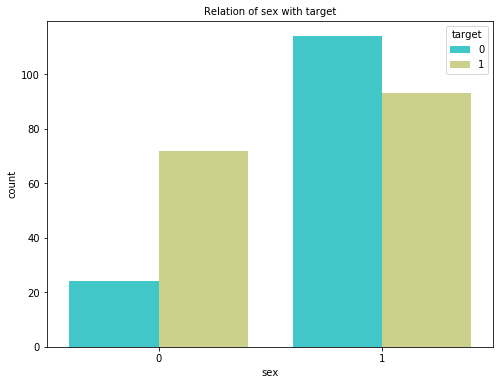

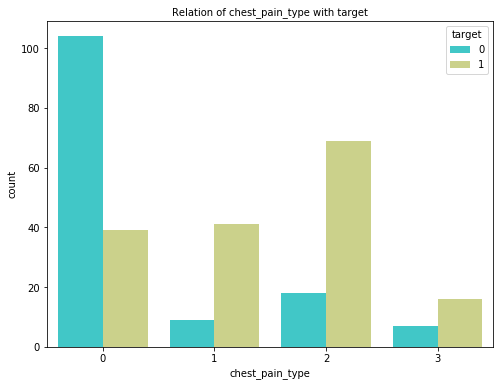

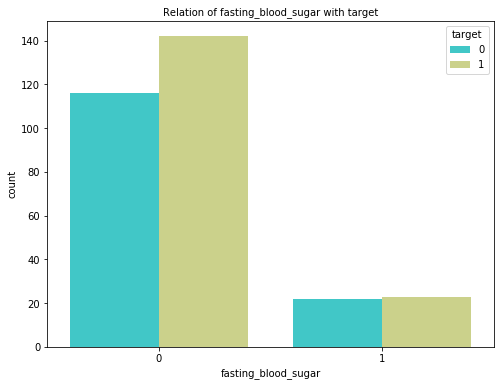

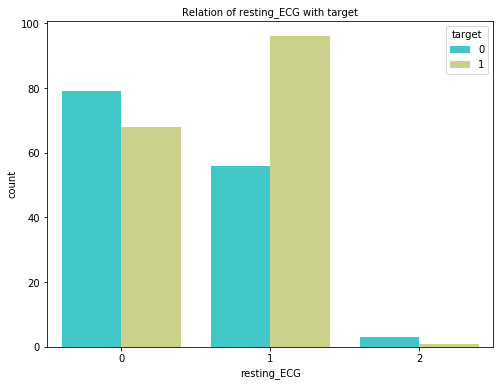

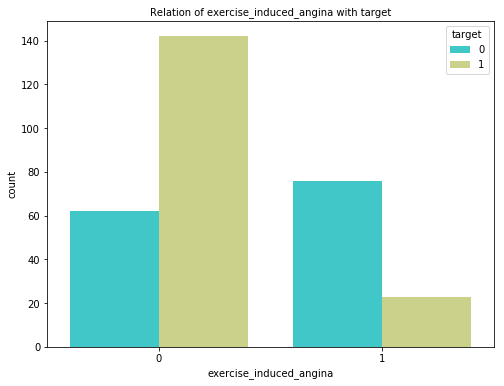

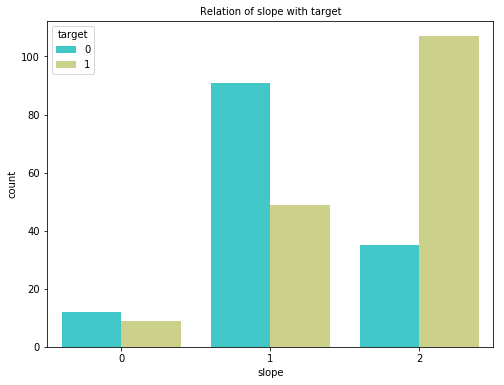

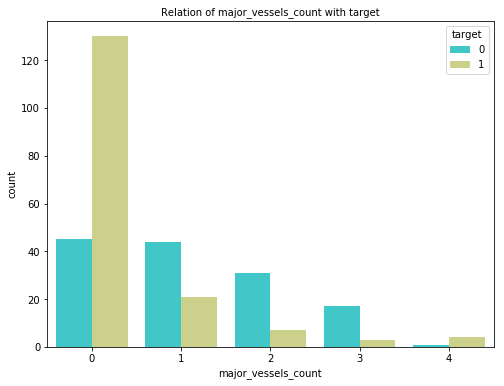

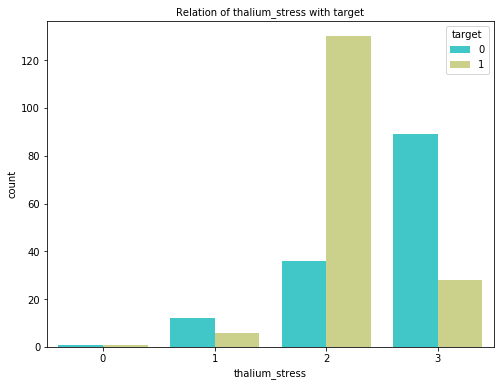

In [28]:
for index,column in enumerate(categorical_cols):
    plt.figure(index,figsize=(8,6))
    sns.countplot(x=column, hue='target', data=df_heart, palette='rainbow')
    plt.title('Relation of {} with target'.format(column), fontsize = 10)

### Observation for Categorical variables - 

1. Sex : Females are more likely to have a Heart Disease than Males. 
2. Chest Pain type : People with Chest Pain type 1,2,3 have more chance of having a Heart Disease.
4. Resting ECG : People with value 1 for resting ECG(abnormal Heart beat) are more likely to have a heart disease. 
5. Exercise Induced Angina : Poeple with No Exercise Induced Angina(0) have heart diseases more than others who have Angina due to exercise. This seems a little contradictory between. 
6. Slope : People with Slope value equal to 2 are more likely to have a Heart Disease than people with Slope value 0 or 1. 
7. Major vessel Count : This has a negative relation with Heart disease. The lesser Number of Major vessels, the more chances are of Heart Disease. 
8. Thalium Stress ST Depression : Poeple with value 2 or 3 are more likely to have Heart Disease